In [144]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [686]:
import math
import re
import sys
import warnings
import logging
from itertools import chain, product
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
import richdem as rd
from pysheds.grid import Grid
from shapely.geometry import LineString, Point, Polygon
from shapely.ops import substring

sys.path.append("/app")
from scripts.gdal_processing import clip_raster_by_vector, create_mosaic, gdal_extent_clipper
from scripts.geom_proc import round_down, round_up
from scripts.metrics_and_visualisations import qh_plot
from scripts.river_geom import (
    distance_to_line,
    get_river_geom,
    rank_to_acc,
    river_points,
)
from scripts.tiff_edit import (
    fill_dem,
    gauge_buffer_creator,
    gauge_to_utm,
    get_post_height_from_dem,
    innudation_raster,
)


# Suppress INFO-level messages temporarily
logging.getLogger("richdem").setLevel(logging.WARNING)
# Suppress specific warning messages
warnings.filterwarnings("ignore", message="W Cell X and Y dimensions are not equal!")
gpd.options.io_engine = "pyogrio"


In [146]:
tan_dem_files = list(Path("/app/data/DEM/TanDEM").glob("*.tif"))

gauges = gpd.read_file("/app/data/QhDEM/geometry/qh_gauges.gpkg")
gauges = gauges.set_index("gauge_id")
ws_file = gpd.read_file("/app/data/Geometry/russia_full.gpkg")
ws_file = ws_file.set_index("gauge_id")

In [147]:
gauges.head()


,name_ru,name_en,geometry
gauge_id,,,
19313,р.Худолаз - пос.Чернышевский,r.Hudolaz - pos.Chernyshevskij,POINT (58.82645 52.63939)
75236,р.Касть - д.Рылово,r.Kast' - d.Rylovo,POINT (40.45643 58.01418)
72559,р.Систа - д.Среднее Райково,r.Sista - d.Srednee Rajkovo,POINT (28.8 59.73)
75222,р.Печегда - пос.Чебаково,r.Pechegda - pos.Chebakovo,POINT (39.56053 57.75352)
71044,р.Ура - с.Ура-Губа,r.Ura - s.Ura-Guba,POINT (32.77889 69.26977)


In [148]:
ws_file.head()

,name_ru,name_en,new_area,ais_dif,geometry
gauge_id,,,,,
9002,р.Енисей - г.Кызыл,r.Enisej - g.Kyzyl,115263.989,0.230,"POLYGON ((96.87792 53.72792, 96.87792 53.72708..."
9022,р.Енисей - пос.Никитино,r.Enisej - pos.Nikitino,184499.118,1.373,"POLYGON ((96.87792 53.72708, 96.88042 53.72708..."
9053,р.Енисей - пос.Базаиха,r.Enisej - pos.Bazaiha,302690.417,0.897,"POLYGON ((92.38292 56.11042, 92.38292 56.10958..."
9112,р.Большой Енисей - с.Тоора-Хем,r.Bol'shoj Enisej - s.Toora-Hem,15448.834,0.969,"POLYGON ((97.07125 52.71625, 97.07125 52.71542..."
9115,р.Большой Енисей - пос.Сейба,r.Bol'shoj Enisej - pos.Sejba,44934.891,0.751,"POLYGON ((96.87792 53.72708, 96.88042 53.72708..."


### Create big masks from TAN dem. Later we'll crop it

In [149]:
gauge_id = "19313"

raster_folder = Path(f"/app/data/QhDEM/rasters/{gauge_id}")
raster_folder.mkdir(exist_ok=True, parents=True)
geometry_folder = Path(f"/app/data/QhDEM/geometry/{gauge_id}")
geometry_folder.mkdir(exist_ok=True, parents=True)

gauge = gauges.loc[[gauge_id], :]

lon, lat = gauge.loc[gauge_id, "geometry"].xy
lon, lat = lon[0], lat[0]


max_lon, min_lon = round_up(lon, round_val=1), round_down(lon, round_val=1)
max_lat, min_lat = round_up(lat, round_val=1), round_down(lat, round_val=1)

gauge_extent = (min_lon, min_lat, max_lon, max_lat)

tile_boundaries = [
    f"N{lat}E0{lon}" if len(str(lon)) < 3 else f"N{lat}E{lon}"
    for lat, lon in product((min_lat, max_lat), (min_lon, max_lon))
]
tiles = list(
    chain.from_iterable(
        [[str(i) for i in tan_dem_files if i.match(f"*{boundary}*")] for boundary in tile_boundaries]
    )
)
elv_vrt_path = create_mosaic(file_path=str(raster_folder), file_name=f"{gauge_id}_tan_elv", tiles=tiles)
gauge_projected, gauge_utm = gauge_to_utm(gauge_series=gauge.loc[gauge_id, "geometry"], return_gdf=True)
gauge_buffer, gauge_extent = gauge_buffer_creator(gauge_geometry=gauge.loc[gauge_id, "geometry"])
gdal_extent_clipper(
    initial_tiff=elv_vrt_path,
    extent=gauge_extent,
    tmp_tiff=f"{raster_folder}/{gauge_id}_elv.tiff",
    final_tiff=f"{raster_folder}/{gauge_id}_elv.tiff",
    crs_epsg=4326,
)
fill_dem(
    dem_tiff=f"{raster_folder}/{gauge_id}_elv.tiff",
    elv_fill=f"{raster_folder}/{gauge_id}_fill.tiff",
)
grid = Grid.from_raster(f"{raster_folder}/{gauge_id}_fill.tiff", data_name="dem_grid")
dem = grid.read_raster(f"{raster_folder}/{gauge_id}_fill.tiff", data_name="dem")
# dem.nodata = np.asarray(dem.nodata, dtype=np.float32)
fdir = grid.flowdir(dem, nodata_out=np.uint8(0))
grid.to_raster(file_name=f"{raster_folder}/{gauge_id}_dir.tiff", data=fdir, data_name="fdir")
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
# Compute accumulation
acc = grid.accumulation(fdir, dirmap=dirmap)
grid.to_raster(file_name=f"{raster_folder}/{gauge_id}_acc.tiff", data=acc, data_name="acc")


### Create rivers from accumulation

In [150]:
# initialize calculation grid
grid = Grid.from_raster(f"{raster_folder}/{gauge_id}_dir.tiff", data_name="fdir_grid")
fdir = grid.read_raster(f"{raster_folder}/{gauge_id}_dir.tiff", data_name="fdir", nodata=np.uint8(0))
acc = grid.read_raster(
    f"{raster_folder}/{gauge_id}_acc.tiff", data_name="acc", nodata=np.float64(np.nan)
)
river_parts = {
    # "small_creeks": grid.extract_river_network(fdir, (1e2 < acc) & (acc <= 1e3)),  # type: ignore
    "big_creeks": grid.extract_river_network(fdir, (1e3 < acc) & (acc <= 1e4)),  # type: ignore
    "small_rivers": grid.extract_river_network(fdir, (1e4 < acc) & (acc <= 1e5)),  # type: ignore
    "medium_rivers": grid.extract_river_network(fdir, (1e5 < acc) & (acc <= 1e6)),  # type: ignore
    "rivers": grid.extract_river_network(fdir, (1e6 < acc) & (acc <= 1e7)),  # type: ignore
    "big_rivers": grid.extract_river_network(fdir, (1e7 < acc) & (acc <= 1e8)),  # type: ignore
    "large_rivers": grid.extract_river_network(fdir, (1e8 < acc)),  # type: ignore
}


### Get closest river

In [151]:
# compile geometry in one GeoDataFrame
temp_res_riv = pd.concat([get_river_geom(rank, network) for rank, network in river_parts.items()])
temp_res_riv["acc_range"] = temp_res_riv.apply(lambda row: rank_to_acc(row), axis=1)
temp_res_riv = temp_res_riv[["id", "rank", "acc_range", "geometry"]]
temp_res_riv = temp_res_riv.reset_index(drop=True)
temp_res_riv = gpd.GeoDataFrame(temp_res_riv, geometry="geometry", crs=4326)  # type: ignore
gauge_crs = gauge_projected.to_crs(epsg=gauge_utm)
gauge_crs = gauge_crs.reset_index(drop=True)

river_network_crs = temp_res_riv.to_crs(epsg=gauge_utm)
river_network_crs = river_network_crs.reset_index(drop=True)
# get lenghth of each river segment
river_network_crs["segment_length"] = river_network_crs.length

river_network_crs["distance"] = river_network_crs["geometry"].apply(
    lambda x: distance_to_line(x, gauge_crs.loc[0, "geometry"])
)
acceptable_rivers = river_network_crs["distance"] < 5000
if river_network_crs.loc[acceptable_rivers].empty:
    pass
else:
    river_network_crs = river_network_crs.loc[acceptable_rivers]
# find nearest river line to gauge point
river_network_crs = river_network_crs.sort_values(["acc_range", "distance"], ascending=False)
river_network_crs = river_network_crs.reset_index(drop=True)

### Cut section from dem for this river element

In [182]:
# convert river for points
point_along_lines = river_points(river_network_crs.loc[[0], ["geometry"]])
reasonable_distance = list(i.distance(gauge_crs.loc[0, "geometry"]) for i in point_along_lines)
closest_point = point_along_lines[np.nanargmin(reasonable_distance)]
# Sample LineString and point
line = river_network_crs.loc[[0], ["geometry"]]  # Example line that goes 1000 meters north

# Step 1: Find the distance along the line where the point lies
point_distance_along_line = line.project(closest_point)[0]

# Step 2: Define the start and end of the cut (500 meters on each side)
start_distance = max(point_distance_along_line - 500, 0)
end_distance = min(point_distance_along_line + 500, line.length[0])

# Step 3: Cut the line segment within the 500-meter range around the point
cut_segment = substring(line.loc[0, "geometry"], start_distance, end_distance)
segment_length = cut_segment.length
qh_segment = gpd.GeoDataFrame(geometry=[cut_segment], crs=gauge_utm)
qh_segment[["name_ru", "name_en"]] = gauge[["name_ru", "name_en"]].values
qh_segment.index.name = "gauge_id"
qh_segment.index = pd.Index([gauge_id])
qh_segment.to_crs(epsg=4326, inplace=True)
qh_segment.to_file(f"{geometry_folder}/{gauge_id}_segment.gpkg", driver="GPKG")
gauge.to_file(f"{geometry_folder}/{gauge_id}_gauge.gpkg", driver="GPKG")
qh_segment.to_crs(epsg=gauge_utm, inplace=True)
# Parameters for extending lines
extension_length = 5000  # Length of new lines from each endpoint

angle1 = math.radians(45)  # Angle for line from start point in radians
angle2 = math.radians(135)  # Angle for line from end point in radians

# Step 1: Extract start and end points
start_point = Point(qh_segment.loc[gauge_id, "geometry"].coords[0])
end_point = Point(qh_segment.loc[gauge_id, "geometry"].coords[-1])
# create dataframe with points to get elevations for them
point_df = gpd.GeoDataFrame(geometry=[start_point, end_point], crs=gauge_utm, index=["start", "end"])
point_df.to_crs(epsg=4326, inplace=True)
# get river slope from first and last point from dem from river
start_height = get_post_height_from_dem(
    pt=point_df.loc["start", "geometry"], tiff_path=f"{raster_folder}/{gauge_id}_fill.tiff"
)
end_height = get_post_height_from_dem(
    pt=point_df.loc["end", "geometry"], tiff_path=f"{raster_folder}/{gauge_id}_fill.tiff"
)
# Step 2: Calculate endpoints for the new lines such that their midpoint matches the original endpoints

# For the start endpoint of the original line
# Calculate the new endpoint for the line extending from the start
start_extension_top = Point(
    start_point.x + extension_length * math.cos(angle1),
    start_point.y + extension_length * math.sin(angle1),
)
start_extension_bottom = Point(
    start_point.x - extension_length * math.cos(angle1),
    start_point.y - extension_length * math.sin(angle1),
)
# Create the new line from the start, with start_point as its midpoint
line_from_start = LineString([start_extension_top, start_extension_bottom])

# For the end endpoint of the original line
# Calculate the new endpoint for the line extending from the end
end_extension_top = Point(
    end_point.x + extension_length * math.cos(angle1),
    end_point.y + extension_length * math.sin(angle1),
)
end_extension_bottom = Point(
    end_point.x - extension_length * math.cos(angle1),
    end_point.y - extension_length * math.sin(angle1),
)
# Create the new line from the end, with end_point as its midpoint
line_from_end = LineString([end_extension_top, end_extension_bottom])

# Step 1: Extract the start and end points of each LineString
line1_start = line_from_start.coords[0]
line1_end = line_from_start.coords[-1]
line2_start = line_from_end.coords[0]
line2_end = line_from_end.coords[-1]

# Step 2: Order the points to form a closed loop for the polygon
# In this case, we use the points in the following order:
# line1_start -> line1_end -> line2_end -> line2_start
polygon_points = [line1_start, line1_end, line2_end, line2_start]

# Step 3: Create the polygon
polygon = Polygon(polygon_points)
polygon = gpd.GeoDataFrame({"geometry": [polygon]})
polygon = polygon.set_crs(epsg=gauge_utm, inplace=True)
polygon.to_crs(epsg=4326, inplace=True)
polygon.to_file(f"/app/data/QhDEM/geometry/19313/{gauge_id}_river_poly.gpkg", driver="GPKG")


### Prepare needed rasters

In [ ]:
# fill dem
clip_raster_by_vector(
    raster_file_path=f"{raster_folder}/{gauge_id}_fill.tiff",
    vector_file_path=f"/app/data/QhDEM/geometry/19313/{gauge_id}_river_poly.gpkg",
    output_file_path=f"{raster_folder}/{gauge_id}_fill_poly.tiff",
)

# dir dem
grid = Grid.from_raster(f"{raster_folder}/{gauge_id}_fill_poly.tiff", data_name="dem_grid")
dem = grid.read_raster(f"{raster_folder}/{gauge_id}_fill_poly.tiff", data_name="dem")
# dem.nodata = np.asarray(dem.nodata, dtype=np.float32)
fdir = grid.flowdir(dem)
grid.to_raster(file_name=f"{raster_folder}/{gauge_id}_dir_poly.tiff", data=fdir, data_name="fdir")


# acc dem
clip_raster_by_vector(
    raster_file_path=f"{raster_folder}/{gauge_id}_acc.tiff",
    vector_file_path=f"/app/data/QhDEM/geometry/19313/{gauge_id}_river_poly.gpkg",
    output_file_path=f"{raster_folder}/{gauge_id}_acc_poly.tiff",
)

In [ ]:
Path(f"{raster_folder}/{gauge_id}_acc.tiff").unlink()
Path(f"{raster_folder}/{gauge_id}_dir.tiff").unlink()
Path(f"{raster_folder}/{gauge_id}_elv.tiff").unlink()
Path(f"{raster_folder}/{gauge_id}_fill.tiff").unlink()


### Q(h) magic

In [167]:
qh_lmfit_file = pd.read_pickle("/app/data/QhDEM/res/qh_full/19313.pkl")

qh_lmfit_file


,q_cms,q_mm_day,lvl_sm,lvl_mbs,lvl_qh
date,,,,,
2008-01-01,1.22,0.111705,113.0,303.65,77.294181
2008-01-02,1.36,0.124524,117.0,303.69,78.061327
2008-01-03,1.59,0.145583,125.0,303.77,79.392638
2008-01-04,1.59,0.145583,125.0,303.77,79.392638
2008-01-05,1.59,0.145583,125.0,303.77,79.392638
...,...,...,...,...,...
2022-12-27,0.67,0.061346,79.0,303.31,74.734779
2022-12-28,0.96,0.087899,87.0,303.39,75.979043
2022-12-29,1.54,0.141005,100.0,303.52,79.096535


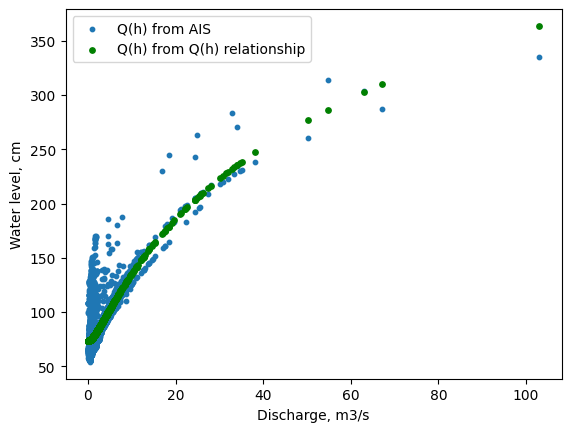

In [168]:
img = qh_plot(qh_lmfit_file)
img


### Create flood examples

In [169]:
flood_zone_folder = Path(f"/app/data/QhDEM/flood_zones/{gauge_id}")
flood_zone_folder.mkdir(exist_ok=True, parents=True)


In [725]:
def truncate(value, digits):
    factor = 10**digits
    return np.round((value * factor) / factor, 2)


def conditional_truncate(value):
    # Apply conditions to determine truncation digits
    if value < 1:
        lvl_info = truncate(value, 2)
    elif value > 1 and value < 5:
        lvl_info = truncate(value, 1)
    else:
        lvl_info = truncate(value, 0)
    return lvl_info


In [751]:
(
    np.max(distribution_q_mm_day[level_partitions == 8]),
    np.median(distribution_q_mm_day[level_partitions == 8]),
)


(8.66, 1.57)

In [756]:
ws_area = ws_file.loc[gauge_id, "new_area"]
acc_coef = (ws_area * 1e6) / (90 * 90)

distribution_levels = qh_lmfit_file["lvl_sm"] / 100
distribution_q_mm_day = qh_lmfit_file["q_cms"]

# Define N equal intervals between the minimum and maximum values
level_intervals = np.linspace(start=0, stop=distribution_levels.max(), num=24)
# Digitize data to assign each value to one of the intervals
level_partitions = np.digitize(distribution_levels, level_intervals)

distribution_dict = dict()
for partition in np.unique(level_partitions):
    number_of_files = len(distribution_levels[level_partitions == partition])
    distribution_dict[number_of_files] = {
        "lvl_sm": np.max(distribution_levels[level_partitions == partition]),
        "q_cms": np.max(distribution_q_mm_day[level_partitions == partition]),
    }

partition_df = (
    pd.DataFrame(distribution_dict).T.reset_index(drop=True).sort_values(by="lvl_sm", ascending=False)
)
partition_df


,lvl_sm,q_cms
12,3.35,103.00
13,2.87,67.20
11,2.45,38.20
10,2.31,35.10
9,2.18,30.20
8,1.70,18.40
7,1.60,17.10
6,1.45,14.00
5,1.31,11.00
4,1.16,8.66


In [757]:
for repetitions, partition_dict in distribution_dict.items():
    innudation_raster(
        gauge_id=gauge_id,
        temp_res_folder=f"/app/data/QhDEM/rasters/{gauge_id}",
        acc_coef=acc_coef,
        predicted_lvl=partition_dict["lvl_sm"],
        event_date=str(repetitions),
        final_res_folder="/app/data/QhDEM/flood_zones/",
    )


### Get Q(h) from innudation

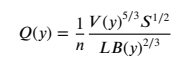

- where Q is discharge at stage y,
- n is the Manning's n roughness coefficient,
- V is volume at y,
- S is channel slope,
- L is the along-flow reach length,
- and B is wetted bed area at y.

Q, V, and B are taken at specific y values so are more formally written as
Q = Q(y), V = V(y), and B = B(y), respectively.

All units are international (SI) given the one in the numerator above n

In [758]:
def manning_parameters(flood_tiff: str, segment_length: float):
    with rasterio.open(flood_tiff) as dataset:
        bounds = dataset.bounds
        central_latitude = (bounds.top + bounds.bottom) / 2
    gauge_flood = rd.LoadGDAL(flood_tiff)

    meters_per_degree_longitude = 111320 * np.cos(np.radians(central_latitude))
    meters_per_degree_latitude = 111320
    _, pixel_width, _, _, _, pixel_height = gauge_flood.geotransform
    # Convert pixel dimensions from degrees to meters
    pixel_width_m = pixel_width * meters_per_degree_longitude
    pixel_height_m = abs(pixel_height * meters_per_degree_latitude)
    # Calculate the area of each pixel in square meters
    pixel_area = pixel_width_m * pixel_height_m

    water_depth = np.array(gauge_flood, dtype=np.float32)
    # get slope
    cell_slope = rd.TerrainAttribute(gauge_flood, attrib="slope_radians")
    slope_riserun = np.sqrt(1 + np.power(cell_slope, 2), dtype=np.float32)

    water_surface_area = pixel_area * len(~np.isnan(gauge_flood))
    channel_bed_area = np.nansum(pixel_area * slope_riserun)

    flood_volume = np.nansum(pixel_area * water_depth)

    river_width = water_surface_area / segment_length

    cross_section_area = flood_volume / segment_length

    wetted_perimeter = channel_bed_area / segment_length

    hydraulic_radius = cross_section_area / wetted_perimeter

    return {
        "water_depth": water_depth,
        "flood_volume": float(flood_volume),
        "river_width": river_width,
        "cross_section_area": cross_section_area,
        "wetted_perimeter": float(wetted_perimeter),
        "hydraulic_radius": float(hydraulic_radius),
        "water_surface_area": water_surface_area,
        "channel_bed_area": float(channel_bed_area),
    }


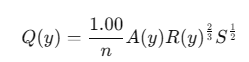

In [759]:
_friction_coefficient = 6e-3
river_slope = (start_height - end_height) / segment_length * 10

for flood_path in list(Path(f"/app/data/QhDEM/flood_zones/{gauge_id}").glob("*.tiff")):
    # Extract the float if the pattern is matched
    match = re.search(r"_(\d+\.\d+)_", flood_path.stem)
    if match:
        predicted_lvl = float(match.group(1))
        manning_dict = manning_parameters(flood_tiff=str(flood_path), segment_length=segment_length)
        q_i = (
            (1 / _friction_coefficient)
            * manning_dict["cross_section_area"]
            * np.power(manning_dict["wetted_perimeter"], 2 / 3)
            * np.power(river_slope, 1 / 2)
        ) * 1e-3
        partition_df.loc[
            partition_df["lvl_sm"].apply(lambda x: conditional_truncate(x)) == predicted_lvl,
            "q_manning",
        ] = q_i
    else:
        print(f"Pattern not found {flood_path}")
partition_df



A Slope calculation (radians)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

W Cell X and Y dimensions are not equal!
t Wall-time = 0.0013112====================== ] (99% - 0.0s - 1 threads)

A Slope calculation (radians)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

W Cell X and Y dimensions are not equal!
t Wall-time = 0.000955892==================== ] (99% - 0.0s - 1 threads)

A Slope calculation (radians)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

W Cell X and Y dimensions are not equal!
t Wall-time = 0.00137938===================== ] (99% - 0.0s - 1 threads)

A Slope calculation (radians)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

W Cell X and Y dimensions are not equa

,lvl_sm,q_cms,q_manning
12,3.35,103.00,137.610848
13,2.87,67.20,98.385645
11,2.45,38.20,50.797688
10,2.31,35.10,46.235750
9,2.18,30.20,42.213043
8,1.70,18.40,25.958311
7,1.60,17.10,22.255288
6,1.45,14.00,18.004184
5,1.31,11.00,13.699591
4,1.16,8.66,10.474714


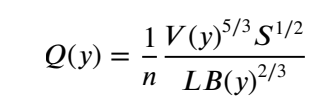

- where Q is discharge at stage y,
- n is the Manning's n roughness coefficient,
- V is volume at y,
- S is channel slope,
- L is the along-flow reach length,
- and B is wetted bed area at y.

Q, V, and B are taken at specific y values so are more formally written as
Q = Q(y), V = V(y), and B = B(y), respectively.

All units are international (SI) given the one in the numerator above n

In [760]:
for flood_path in list(Path(f"/app/data/QhDEM/flood_zones/{gauge_id}").glob("*.tiff")):
    # Extract the float if the pattern is matched
    match = re.search(r"_(\d+\.\d+)_", flood_path.stem)
    if match:
        predicted_lvl = float(match.group(1))
        manning_dict = manning_parameters(flood_tiff=str(flood_path), segment_length=segment_length)
        numerator = np.power(manning_dict["flood_volume"], 5 / 3) * np.power(river_slope, 1 / 2)
        denominator = segment_length * np.power(manning_dict["wetted_perimeter"], 2 / 3)
        q_i = (1 / _friction_coefficient) * (numerator / denominator)
        # Apply truncation logic to predicted_lvl based on its value
        partition_df.loc[
            partition_df["lvl_sm"].apply(lambda x: conditional_truncate(x)) == predicted_lvl,
            "q_manning_odd",
        ] = q_i
    else:
        print(f"Pattern not found {flood_path}")
partition_df



A Slope calculation (radians)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

W Cell X and Y dimensions are not equal!
t Wall-time = 0.000705849==================== ] (99% - 0.0s - 1 threads)

A Slope calculation (radians)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

W Cell X and Y dimensions are not equal!
t Wall-time = 0.000690252==================== ] (99% - 0.0s - 1 threads)

A Slope calculation (radians)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

W Cell X and Y dimensions are not equal!
t Wall-time = 0.000691226==================== ] (99% - 0.0s - 1 threads)

A Slope calculation (radians)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

W Cell X and Y dimensions are not equa

,lvl_sm,q_cms,q_manning,q_manning_odd
12,3.35,103.00,137.610848,792990.414357
13,2.87,67.20,98.385645,577189.745041
11,2.45,38.20,50.797688,588390.980525
10,2.31,35.10,46.235750,520936.600117
9,2.18,30.20,42.213043,463912.397237
8,1.70,18.40,25.958311,308983.484119
7,1.60,17.10,22.255288,289494.161669
6,1.45,14.00,18.004184,251949.495182
5,1.31,11.00,13.699591,233577.967592
4,1.16,8.66,10.474714,203050.343834


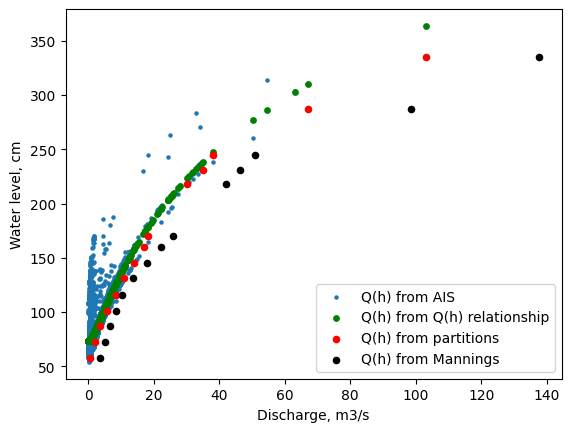

In [761]:
partition_df["lvl_sm"] *= 100
img = qh_plot(qh_lmfit_file, partition_df=partition_df, manning_df=partition_df)
img